In [1]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split
from hyperopt import hp
import imp
import copy

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

RDKit WARNING: [10:57:14] Enabling RDKit 2019.09.3 jupyter extensions


In [38]:
from modules.data import data_maker
from modules.RNN import double_RNN
from modules.fit import Model, fit, predict, mae, rmse, load_exp
from modules.data import pka_scaler
from modules.myhyperopt import hyperopt_func
from modules.MPNN import double_MPNN

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [148]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

In [40]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
datasets = data_maker(solute, solvent, pka)

In [44]:
DMPNN = Model(name='D-MPNN',
              model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='ReLU', 
                                atom_messages=False, dropout=0, interaction=None, readout='sum'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
DMPNN_att = Model(name='D-MPNN with attention',
              model=double_MPNN(MP_depth=4, MP_hidden=128, NN_depth=4, NN_hidden=64, activation='ELU', 
                                atom_messages=False, dropout=0, interaction='tanh', readout='mean'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
MPNN = Model(name='MPNN',
             model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='LeakyReLU', 
                                  atom_messages=True, dropout=0, interaction=None, readout='sum'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
MPNN_att = Model(name='MPNN with attention',
             model=double_MPNN(MP_depth=2, MP_hidden=64, NN_depth=4, NN_hidden=512, activation='ReLU', 
                                  atom_messages=True, dropout=0, interaction='tanh', readout='max'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
RNN = Model(name='RNN',
            model=double_RNN(NN_depth=3, NN_hidden=512, RNN_hidden=512, activation='ReLU', dropout=0.3,
                             features=300, interaction=None, readout='max'),
            lr=0.001,
            batch_size=32,
            model_type='torch',
            data_type='sentences')
RNN_att = Model(name='RNN with attention',
                model=double_RNN(NN_depth=1, NN_hidden=1024, RNN_hidden=512, activation='PReLU', dropout=0.1,
                                 features=300, interaction='exp', readout='max'),
                lr=0.001,
                batch_size=32,
                model_type='torch',
                data_type='sentences')
RF_desc = Model(name='Random forest with descriptors',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='descriptors')
RF_ECFP = Model(name='Random forest with ECFP',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='ECFP')
MLP_desc = Model(name='MLP with descriptors',
                 model=MLPRegressor(activation='logistic', batch_size=32, early_stopping=True, hidden_layer_sizes=(512, 256, 128), solver='adam'),
                 model_type='sklearn',
                 data_type='descriptors')
MLP_ECFP = Model(name='MLP with ECFP',
                 model=MLPRegressor(activation='relu', batch_size=16, early_stopping=True, hidden_layer_sizes=(256, 128, 64), solver='adam'),
                 model_type='sklearn',
                 data_type='ECFP')
XGB_desc = Model(name='XGBoost with descriptors',
                 model=XGBRegressor(colsample_bytree=0.7, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.9),
                 model_type='sklearn',
                 data_type='descriptors')
XGB_ECFP = Model(name='XGBoost with ECFP',
                 model=XGBRegressor(colsample_bytree=0.6, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.8),
                 model_type='sklearn',
                 data_type='ECFP')
#list of all models for testing
models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]
#models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att]
#models = [RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]

In [153]:
#loading models
for m in models:
    print(m.name)
    data = datasets[m.data_type]
    load_exp(m, "Holdout test", data, CV_ids)

D-MPNN
D-MPNN with attention
MPNN
MPNN with attention
RNN
RNN with attention
Random forest with descriptors
Random forest with ECFP
MLP with descriptors
MLP with ECFP
XGBoost with descriptors
XGBoost with ECFP


MPNN with attention
water 1.0456532 1.3918917
DCE 2.624563 3.519341
acetonitrile 1.544481 1.9754378
DMF 1.0339706 1.2270823
DMSO 0.9675365 1.2396258
THF 1.2191323 1.7578944


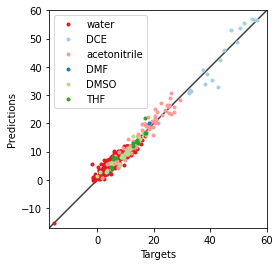

XGBoost with descriptors
water 0.8089893752193799 1.1825499894357163
DCE 2.1646206467239946 2.798472536524215
acetonitrile 1.8011907728672027 2.7051394948016636
DMF 1.4110994267463677 1.7210087974206592
DMSO 1.3864960313989565 1.9353554438463898
THF 1.192451421297514 1.5070196370903104


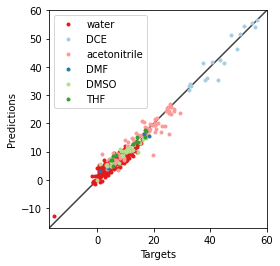

In [154]:
##qqplots
solv_set = list(set(solvent))
solvent_name_key = {"CS(=O)C":"DMSO","CC#N":"acetonitrile","C(CCl)Cl":"DCE","CN(C)C=O":"DMF","C1CCOC1":"THF","O":"water"}
solv_names = ["water","DCE","DMF","DMSO","THF","acetonitrile"]
solv
colour_key = {'DCE':'#a6cee3','DMF':'#1f78b4','DMSO':'#b2df8a','THF':'#33a02c','acetonitrile':'#fb9a99','water':'#e31a1c'}
solv_ids = ddict()
for solv in solv_set:
    solv_ids[solv] = [i for i,x in enumerate(solvent) if x == solv and i in holdout_ids]
for m in [MPNN_att,XGB_desc]:
    print(m.name)
    data = datasets[m.data_type]
    targets, outputs = predict(m, "Holdout test", data, solv_ids['O'])
    solv_name = solvent_name_key['O']
    plt.plot(targets, outputs, 'o', markersize=3,label=solv_name, c=colour_key[solv_name])
    print('water', mae(targets,outputs),rmse(targets,outputs))
    for solv in solv_set:
        if solv not in 'O':
            targets, outputs = predict(m, "Holdout test", data, solv_ids[solv])
            solv_name = solvent_name_key[solv]
            plt.plot(targets, outputs, 'o', markersize=3,label=solv_name, c=colour_key[solv_name])
            print(solv_name, mae(targets,outputs),rmse(targets,outputs))

    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    lims = [-17,60]
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axes=plt.gca()
    axes.set_aspect('equal')
    axes.set_xlim(lims)
    axes.set_ylim(lims)
    axes.legend()
    plt.show()

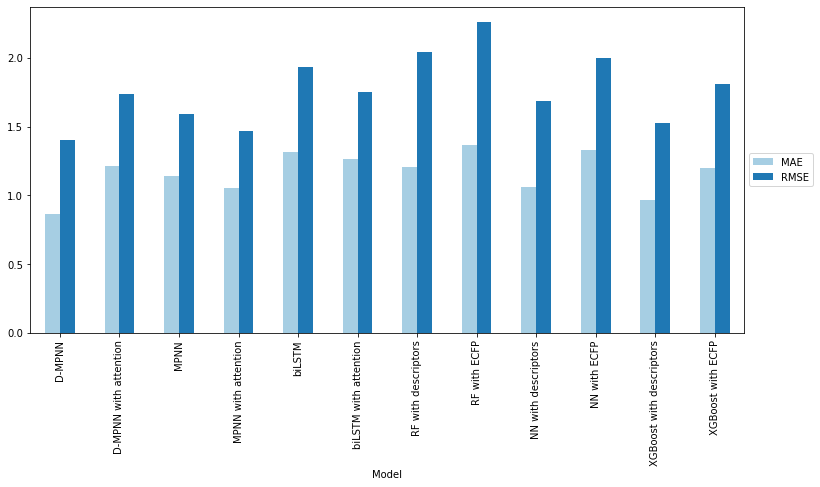

    Unnamed: 0                     Model   MAE  RMSE
0            0                    D-MPNN 0.863 1.404
1            1     D-MPNN with attention 1.217 1.735
2            2                      MPNN 1.144 1.593
3            3       MPNN with attention 1.053 1.468
4            4                    biLSTM 1.312 1.935
5            5     biLSTM with attention 1.262 1.752
6            6       RF with descriptors 1.207 2.043
7            7              RF with ECFP 1.366 2.258
8            8       NN with descriptors 1.063 1.685
9            9              NN with ECFP 1.329 2.000
10          10  XGBoost with descriptors 0.964 1.525
11          11         XGBoost with ECFP 1.203 1.809


In [157]:
#holdout test

df = pd.read_csv('finalised_results/holdout_test_new.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
ax = df.plot.bar(x='Model', y=['MAE','RMSE'], color=colours)

fig = ax.get_figure()
fig.set_size_inches(16, 6)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print(df)

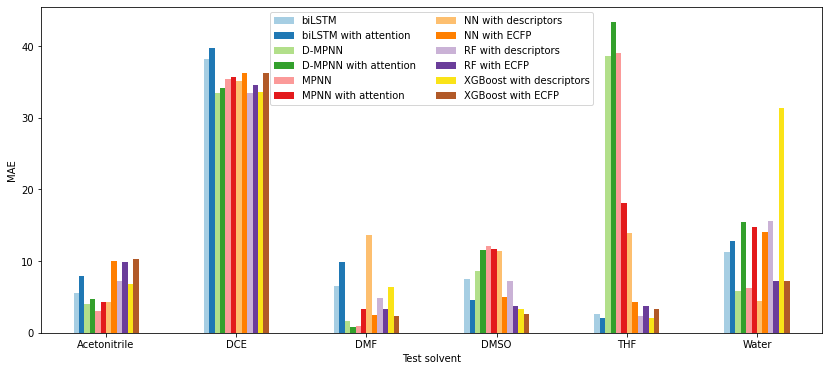

In [140]:
#LOSO
df = pd.read_csv('finalised_results/LOSO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)

solvent_name_key = {"CS(=O)C":"DMSO","CC#N":"Acetonitrile","C(CCl)Cl":"DCE","CN(C)C=O":"DMF","C1CCOC1":"THF","O":"Water"}
df = df.replace(solvent_name_key)

df_pivot = pd.pivot_table(df, values="MAE", index="LOSO solvent", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
           '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#FAE318','#b15928']

ax = df_pivot.plot.bar(color=colours, linewidth=5)
fig = ax.get_figure()
fig.set_size_inches(14, 6)
ax.set_xlabel("Test solvent")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 

ax.legend(loc='best',ncol=2)
plt.savefig('LOSO.png')
plt.show()

In [150]:
solute_charges = [GetFormalCharge(Chem.MolFromSmiles(mol)) for mol in solute]
charge = 2
ids = [i for i, x in enumerate(solute_charges) if x == charge]
for i in ids:
    print(i,solute[i],pka[i])

48 CC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 2.77
95 Nc1ccc2[nH+]ccnc2[nH+]1 -2.0
153 CCCCC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 2.96
279 CC(C)CC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 3.06
329 C[NH+]1CCN(C2=c3ccccc3=[NH+]c3ccc(Cl)cc3N2)CC1 3.9
352 CCC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 2.82
506 CCCCCCCC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 3.32
583 C[N+](C)(C)c1ccc([NH3+])cc1 2.44
629 CCCCCCC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 3.21
677 C[NH2+]CCc1cccc[nH+]1 3.9
790 CCC[C@@H](C)[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 3.42
981 CC[NH+](CC)CCOC(=O)c1ccc([NH3+])cc1 2.0
1182 CC(C)(C[NH3+])C[NH3+] 8.18
1260 CC[NH+](CC)CC[NH+](CC)CC 6.18
1270 Nc1ccc([NH3+])c[nH+]1 2.13
1570 [NH3+]c1ccc2[nH+]ccnc2n1 -2.0
1591 CC(C)[N@H+](CC[N+]1(C)CCCCC1)c1ccccc1 3.26
2040 C[N@H+](CC[N+]1(C)CCCCC1)c1ccccc1 2.61
2305 C[N+](C)(C)c1cccc([NH3+])c1 2.22
2321 C[NH+](C)CCN(Cc1ccccc1)c1cccc[nH+]1 3.92
2374 C[NH+](C)c1cccc([N+](C)(C)C)c1 2.6
2430 CCCCCC[N@@H+](CC[N+]1(C)CCCCC1)c1ccccc1 3.13
2487 CC[NH+](CC)CCC[NH+](CC)CC 8.2
2608 C[N+]1(CC[NH+](c2c

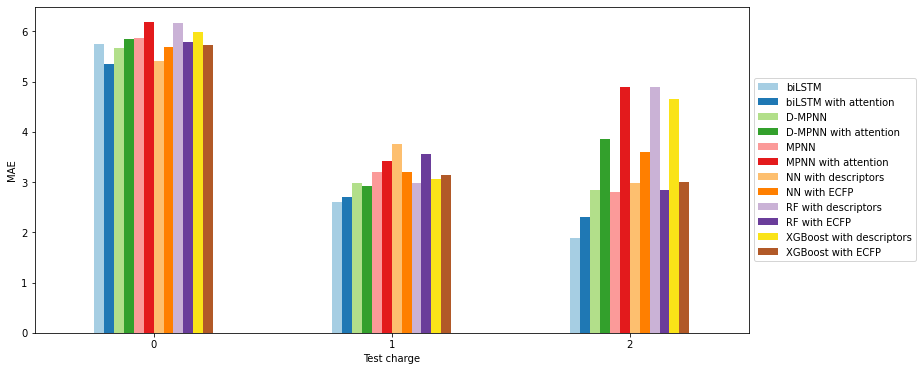

In [152]:
#LOCO
df = pd.read_csv('finalised_results/LOCO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOCO charge", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax = df_pivot.plot.bar(color=colours)
fig = ax.get_figure()
fig.set_size_inches(16, 6)
ax.set_xlabel("Test charge")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])



# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('LOCO.png')
plt.show()

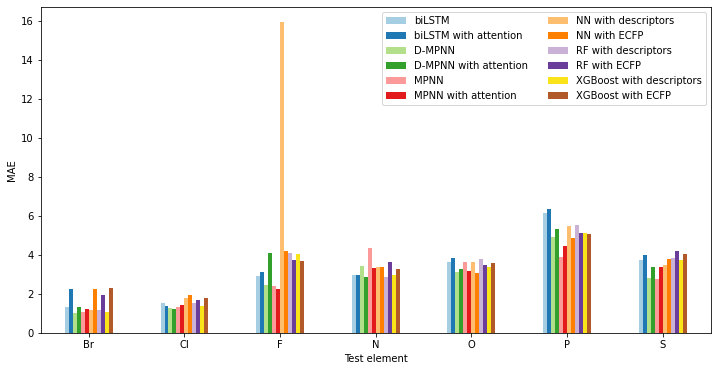

In [135]:
#LOEO
df = pd.read_csv('finalised_results/LOEO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOEO element", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax = df_pivot.plot.bar(color=colours)
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_xlabel("Test element")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 

ax.legend(loc='best',ncol=2)
plt.savefig('LOEO.png')
plt.show()

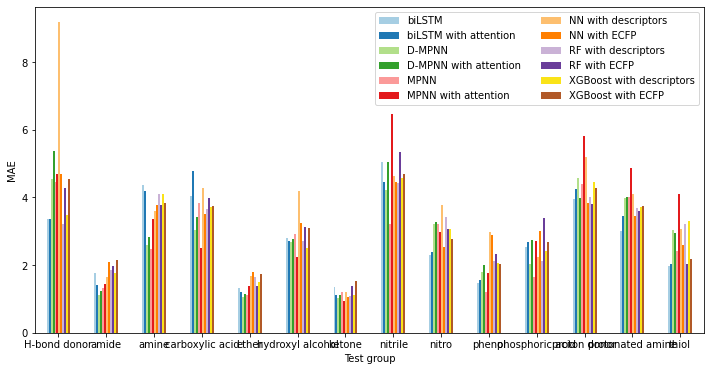

In [136]:
#LOFO
df = pd.read_csv('finalised_results/LOFO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOFO group", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax = df_pivot.plot.bar(color=colours)
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_xlabel("Test group")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 

ax.legend(loc='best', ncol=2)
plt.savefig('LOFO.png')
plt.show()

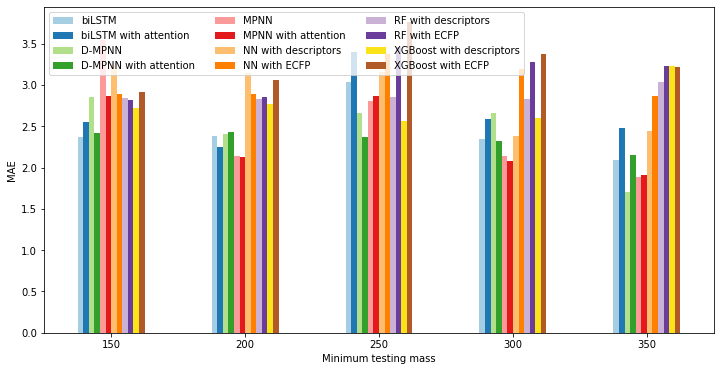

In [137]:
#LOMO_high
df = pd.read_csv('finalised_results/LOMO_high_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOMO mass cutoff", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax = df_pivot.plot.bar(color=colours)
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_xlabel("Minimum testing mass")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 

ax.legend(loc='best',ncol=3)
plt.savefig('LOMO_high.png')
plt.show()

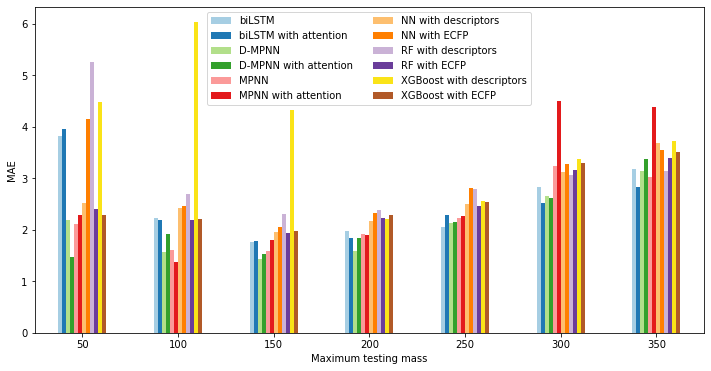

In [138]:
#LOMO_low
df = pd.read_csv('finalised_results/LOMO_low_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOMO mass cutoff", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax = df_pivot.plot.bar(color=colours)
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_xlabel("Maximum testing mass")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 

ax.legend(loc='best', ncol=2)
plt.savefig('LOMO_low.png')
plt.show()

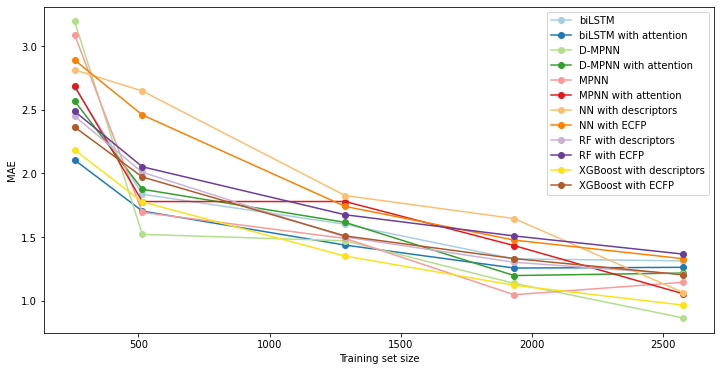

In [161]:
#train_prop_test
df = pd.read_csv('finalised_results/train_prop_test_new.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="Train size", columns="Model")
cols = list(df_pivot.columns.values)
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax = df_pivot.plot(color=colours, style='-o')
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_xlabel("Training set size")
ax.set_ylabel("MAE")
plt.xticks(rotation=0) 

# Put a legend to the right of the current axis
ax.legend(loc='upper right')
plt.savefig('prop.png')
plt.show()

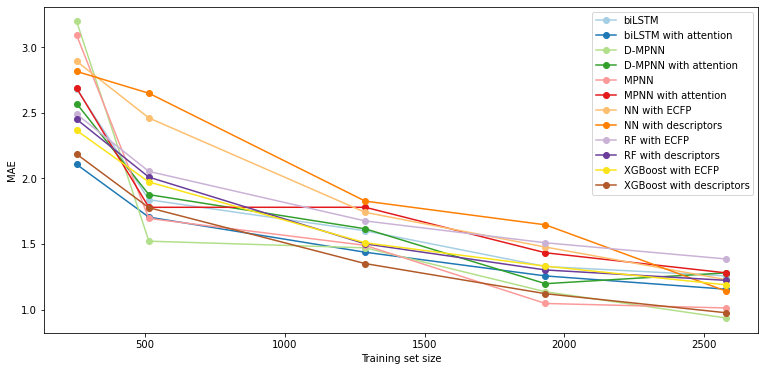

In [160]:
#train_prop_test
df = pd.read_csv('finalised_results/train_prop_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df["Model"] = df["Model"].astype("category")
df["Model"].cat.set_categories(["biLSTM","biLSTM with attention",'D-MPNN','D-MPNN with attention','MPNN','MPNN with attention',
                               'NN with ECFP','NN with descriptors','RF with ECFP','RF with descriptors','XGBoost with ECFP','XGBoost with descriptors'],inplace=True)
df_pivot = pd.pivot_table(df, values="MAE", index="Train size", columns="Model")

ax = df_pivot.plot(color=colours, style='-o')
fig = ax.get_figure()
fig.set_size_inches(16, 6)
ax.set_xlabel("Training set size")
ax.set_ylabel("MAE")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right')

plt.show()